<a href="https://colab.research.google.com/github/Jaisu-1/ResNets-Cifar10/blob/master/ResNet32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

In [0]:
device = 'cuda'
torch.cuda.is_available()

True

In [0]:
tb = SummaryWriter()

In [0]:
cost_list = []
precision_list = []

In [0]:
def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

In [0]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [0]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [0]:
def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])

In [0]:
def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


In [0]:
workers = 4
epochs = 200
start_epochs = 0
batch_size = 128
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
print_freq = 50
save_every = 10
best_prec1 = 0

In [0]:
model = torch.nn.DataParallel(resnet44())
model.cuda()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [0]:
cudnn.benchmark = True

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=workers, pin_memory=True)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
              milestones=[100, 150], last_epoch=start_epochs - 1)

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input_var = input.cuda()
        target_var = target

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
        
    cost_list.append(losses.val)
    precision_list.append(top1.val)
    tb.add_scalar('Loss', losses.val, epoch)
    tb.add_scalar('Precision', top1.val, epoch)

In [0]:
def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg

In [0]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:
def save_checkpoint(state, is_best, filename = 'checkpoint.pth'):
  torch.save(state, filename)

In [0]:
for epoch in range(start_epochs, epochs):

        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        if epoch > 0 and epoch % save_every == 0:
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best)

        save_checkpoint({
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)


current lr 1.00000e-01
Epoch: [0][0/391]	Time 0.691 (0.691)	Data 0.384 (0.384)	Loss 3.1390 (3.1390)	Prec@1 12.500 (12.500)
Epoch: [0][50/391]	Time 0.039 (0.058)	Data 0.000 (0.008)	Loss 2.1212 (2.6094)	Prec@1 15.625 (18.781)
Epoch: [0][100/391]	Time 0.044 (0.052)	Data 0.000 (0.004)	Loss 1.7598 (2.2956)	Prec@1 30.469 (21.805)
Epoch: [0][150/391]	Time 0.042 (0.049)	Data 0.000 (0.003)	Loss 1.8284 (2.1461)	Prec@1 23.438 (24.338)
Epoch: [0][200/391]	Time 0.039 (0.048)	Data 0.000 (0.002)	Loss 1.7846 (2.0385)	Prec@1 27.344 (26.699)
Epoch: [0][250/391]	Time 0.040 (0.048)	Data 0.000 (0.002)	Loss 1.6729 (1.9525)	Prec@1 39.062 (29.221)
Epoch: [0][300/391]	Time 0.042 (0.047)	Data 0.000 (0.001)	Loss 1.4972 (1.8878)	Prec@1 39.844 (31.307)
Epoch: [0][350/391]	Time 0.044 (0.047)	Data 0.001 (0.001)	Loss 1.4602 (1.8330)	Prec@1 42.188 (33.182)
Test: [0/79]	Time 0.210 (0.210)	Loss 1.7491 (1.7491)	Prec@1 41.406 (41.406)
Test: [50/79]	Time 0.029 (0.029)	Loss 1.6849 (1.5564)	Prec@1 42.188 (44.225)
 * Prec@1 4

In [0]:
next(model.parameters()).is_cuda

True

In [0]:
print(best_prec1)

93.0


In [0]:
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
  return total_params


In [0]:
print(pytorch_count_params(model))

NameError: ignored

In [0]:
print(prec1)

92.88


In [0]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

In [0]:
import matplotlib.pyplot as plt
import numpy as np


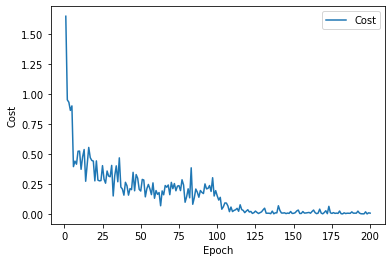

In [0]:
plt.plot(np.arange(1, epochs+1), cost_list, label='Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [0]:
plt.savefig("cost-epoch-resnet20.png")

<Figure size 432x288 with 0 Axes>

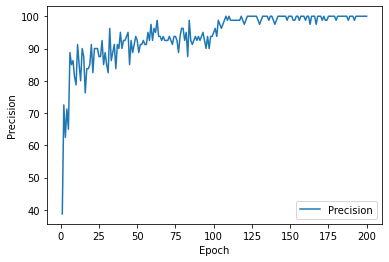

In [0]:
plt.plot(np.arange(1, epochs+1), precision_list, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [0]:


def count_parameters(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name, ':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name, ':', num_param)
            total_param += num_param
    return total_param

In [0]:
print('number of trainable parameters =', count_parameters(model))


module.conv1.weight : 16x3x3x3 = 432
module.bn1.weight : 16
module.bn1.bias : 16
module.layer1.0.conv1.weight : 16x16x3x3 = 2304
module.layer1.0.bn1.weight : 16
module.layer1.0.bn1.bias : 16
module.layer1.0.conv2.weight : 16x16x3x3 = 2304
module.layer1.0.bn2.weight : 16
module.layer1.0.bn2.bias : 16
module.layer1.1.conv1.weight : 16x16x3x3 = 2304
module.layer1.1.bn1.weight : 16
module.layer1.1.bn1.bias : 16
module.layer1.1.conv2.weight : 16x16x3x3 = 2304
module.layer1.1.bn2.weight : 16
module.layer1.1.bn2.bias : 16
module.layer1.2.conv1.weight : 16x16x3x3 = 2304
module.layer1.2.bn1.weight : 16
module.layer1.2.bn1.bias : 16
module.layer1.2.conv2.weight : 16x16x3x3 = 2304
module.layer1.2.bn2.weight : 16
module.layer1.2.bn2.bias : 16
module.layer1.3.conv1.weight : 16x16x3x3 = 2304
module.layer1.3.bn1.weight : 16
module.layer1.3.bn1.bias : 16
module.layer1.3.conv2.weight : 16x16x3x3 = 2304
module.layer1.3.bn2.weight : 16
module.layer1.3.bn2.bias : 16
module.layer1.4.conv1.weight : 16x16x3x